# Image Processing SoSe 2024 - Assignment - 04

### Deadline is 23.05.2024 at 12:00 p.m.

#### Students: Minh Tuan Nguyen, Vinzent Hannes Jörß

Please solve the assignments together with a partner.

Make sure the code runs without errors, when clicking `Kernel` -> `Restart Kernel & Run All Cells`. Then save the notebook and upload your submission.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import random
from io import BytesIO
from PIL import Image

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - Qualify sharpness and noise - 5 Points

Determine the noise and sharpness in the images. Plot image number vs noise

Please download sample picture from [here](http://sipi.usc.edu/database/misc.zip) and place them next to your assignment (inside the misc folder).

In [3]:
# Load the pictures here
sample_images = []
direc = 'misc/' # directory of the sample pictures relative to your notebook
for number in [1,3,5,6]:
    sample_images.append(np.array(Image.open(direc+'4.2.0'+str(number)+'.tiff')))
for name in ['house']:
    sample_images.append(np.array(Image.open(direc+name+'.tiff')))

<BarContainer object of 5 artists>

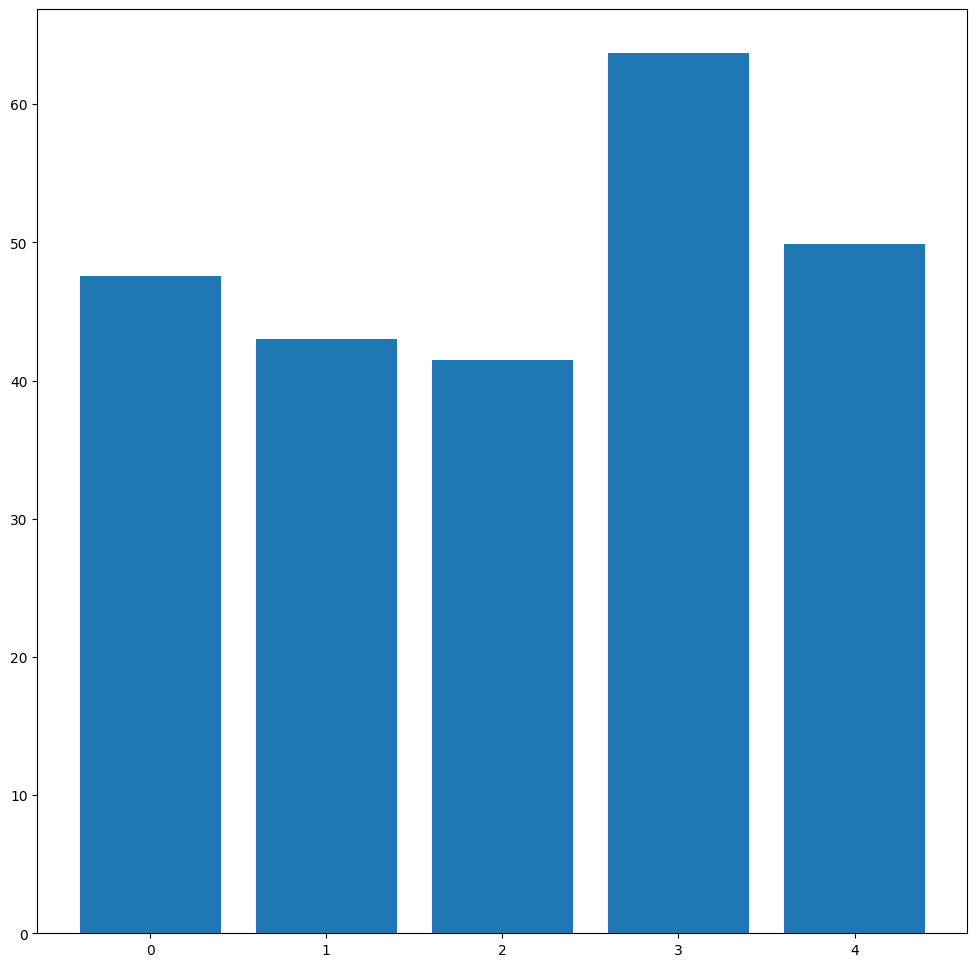

In [5]:
def qualify_noise(img):
    """Qualify the noise based on the std of a gaussian model.
       You may find a window that is constant in the images.
    """
    img = img.reshape(-1, 3)
    img = img.mean(axis=1)
    sigma = np.std(img)
    return sigma

plt.bar(range(len(sample_images)), [qualify_noise(i) for i in sample_images])

In [16]:
def qualify_sharpness(img):
    """Qualify the sharpness based on the average pixel differences."""
    img = img.mean(axis=2)
    dx, dy = np.gradient(img)
    sharpness = np.sqrt(dx**2 + dy**2)
    return sharpness.mean()

plt.bar(range(len(sample_images)), [qualify_sharpness(i) for i in sample_images])

<BarContainer object of 5 artists>

Does the result match your expectations? If not what processing step can be done?

> No. Image 3 appears to be a lot more noisy than the other images. This is because the image has very high contrast between dark and bright areas. The distribution is multimodal and it affects the global standard deviation. This can be improved by splitting the image into small regions and taking the average noise across all regions.

# Exercise 2 - SSIM JPEG Compression - 5 Points
Implement the SSIM metric and apply it on the given compressed images

In [12]:
def jpeg_encode(img, quality):
    pil_img = Image.fromarray(img)
    buffer = BytesIO()
    pil_img.save(buffer, "JPEG", quality=quality)
    return buffer

def jpeg_decode(buffer):
    img = Image.open(buffer)
    return np.array(img)

def jpeg_quality_filter(img, quality):
    as_jpeg = jpeg_encode(img, quality)
    return jpeg_decode(as_jpeg)

In [13]:
images_for_jpeg = sample_images[2::]
len(images_for_jpeg)

3

In [14]:
images10 = [jpeg_quality_filter(img, 10) for img in images_for_jpeg]
images50 = [jpeg_quality_filter(img, 50) for img in images_for_jpeg]
images80 = [jpeg_quality_filter(img, 80) for img in images_for_jpeg]

0


1


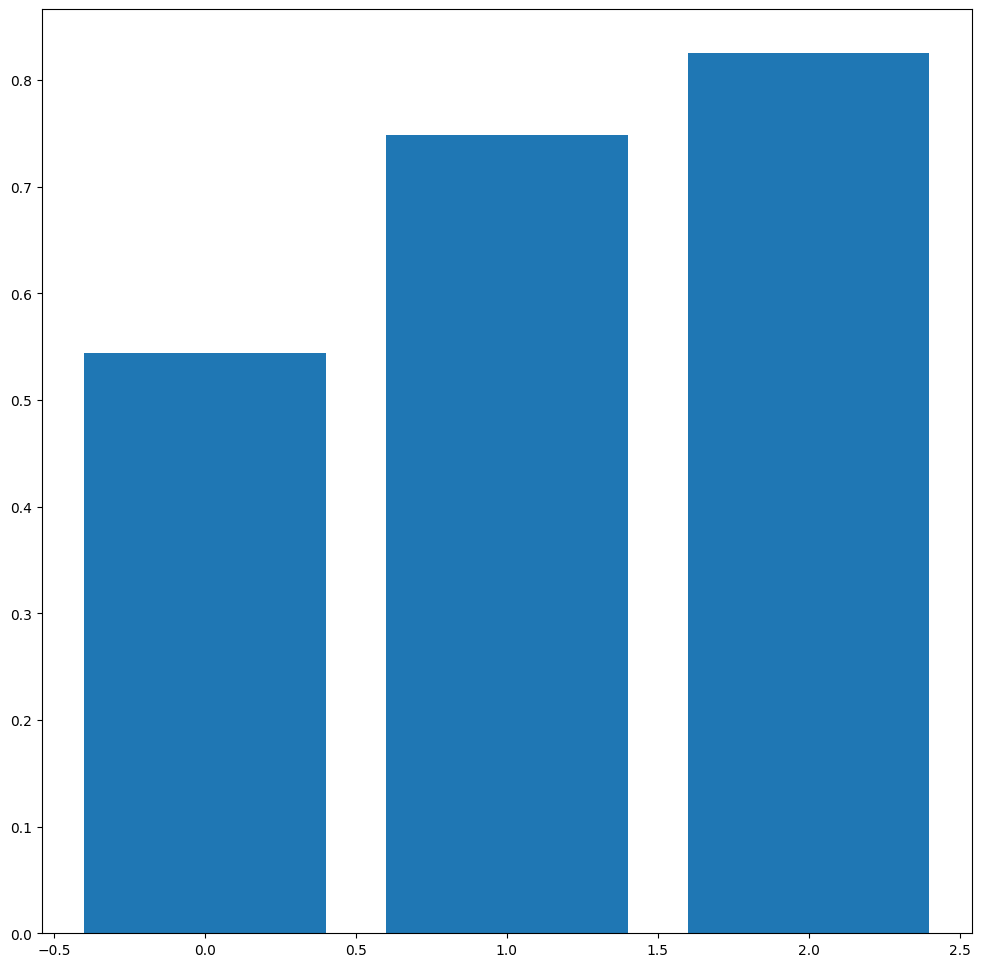

2


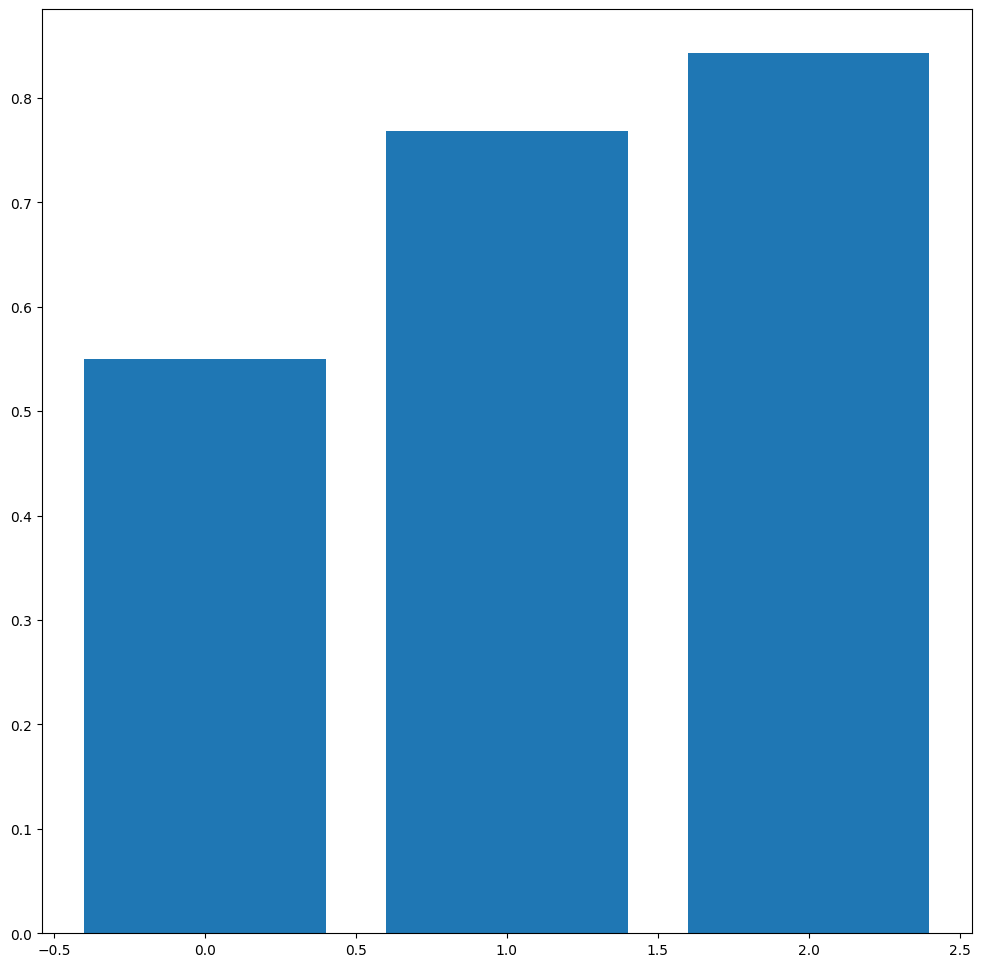

In [15]:
def ssim(img, filtered_img):
    """The SSIM similarity measure. Use the parameters from the paper 
    as on the second to last slide from the lecture"""
    img = img.mean(axis=2)
    filtered_img = filtered_img.mean(axis=2)

    w = np.array([8, 8])  # window size

    mu_x = np.empty(img.shape - w + 1)
    mu_y = np.empty_like(mu_x)
    sigma_x = np.empty_like(mu_x)
    sigma_y = np.empty_like(mu_x)
    sigma_xy = np.empty_like(mu_x)

    for (i, j), _ in np.ndenumerate(mu_x):
        x = img[i:i+w[0], j:j+w[1]].flatten()
        y = filtered_img[i:i+w[0], j:j+w[1]].flatten()
        mu_x[i, j] = x.mean()
        mu_y[i, j] = y.mean()
        x = x - mu_x[i, j]
        y = y - mu_y[i, j]
        sigma_x[i, j] = np.sqrt(np.dot(x, x) / x.size)
        sigma_y[i, j] = np.sqrt(np.dot(y, y) / y.size)
        sigma_xy[i, j] = np.dot(x, y) / (x.size - 1)

    c1 = 0.0001
    c2 = 0.0001

    _ssim = (2*mu_x*mu_y + c1) / (mu_x**2 + mu_y**2 + c1) * (2*sigma_xy + c2) / (sigma_x**2 + sigma_y**2 + c2)

    return _ssim.mean()

for i, img in enumerate(images_for_jpeg):
    print(i)
    compressed_images = [images10[i], images50[i], images80[i]]
    plt.bar(range(len(compressed_images)),
             [ssim(img, comp) for comp in compressed_images])
    plt.show()